# Momentum_Strategy

In [1]:
# 设定data路径
import os

os.chdir(r'F:\Study\Study Files\05大三上\金融统计分析\实验课1\1_Rawdata')

current_path = os.getcwd()
print(current_path)

F:\Study\Study Files\05大三上\金融统计分析\实验课1\1_Rawdata


## 策略构建

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
data = pd.read_csv('TRD_Mnth.csv')
data = data.drop(['Markettype'], axis=1)

data.head()

,Stkcd,Trdmnt,Msmvosd,Mretwd
0,1,1991-04,1157520.00,NaN
1,1,1991-05,1016010.00,-0.122253
2,1,1991-06,900735.00,-0.113459
3,1,1991-07,782810.00,-0.130921
4,1,1991-08,674833.82,-0.411588


In [3]:


# 确保数据按股票代码和日期排序
data = data.sort_values(['Stkcd', 'Trdmnt'])
data['Trdmnt'] = pd.to_datetime(data['Trdmnt'])

# 设置回测期
data_trade = data[(data['Trdmnt'] >= '2021-01-01') & (data['Trdmnt'] <= '2022-12-31')]

# 初始化一个3x3的DataFrame来保存不同策略的收益
result = pd.DataFrame(index=[1,3,6], columns=[1,3,6])

# 获取唯一的年月，作为回测的月份点
unique_year_month = data_trade['Trdmnt'].dt.to_period('M').unique()


# 开始循环：不同形成期和持有期
for form_period in [1,3,6]:
    for hold_period in [1,3,6]:
        
        all_returns = []
        
        # 遍历每一个唯一的年月
        for current_ym in unique_year_month:
            
            # 将年月转换为实际的日期
            end_date = pd.to_datetime(current_ym.to_timestamp())
            start_date = end_date - pd.DateOffset(months=form_period)  # 形成期起始日期
            hold_end_date = end_date + pd.DateOffset(months=hold_period)  # 持有期结束日期
            
            if hold_end_date > data['Trdmnt'].max():
                continue
            
            # 计算形成期内的累计收益
            mask = (data['Trdmnt'] > start_date) & (data['Trdmnt'] <= end_date)
            form_returns = data.loc[mask].groupby('Stkcd')['Mretwd'].apply(lambda x: (1 + x).prod() - 1)

            # 检查在持有期间是否有数据
            mask = (data['Trdmnt'] > end_date) & (data['Trdmnt'] <= hold_end_date)
            available_stocks = data.loc[mask]['Stkcd'].unique()
            
            # 仅保留那些在持有期内有数据的股票
            form_returns = form_returns[form_returns.index.isin(available_stocks)]
            
            # 从剩下的股票中确定赢家和输家
            
            winners = form_returns.nlargest(10).index
            losers = form_returns.nsmallest(10).index
            
            # 计算持有期收益
            mask = (data['Trdmnt'] > end_date) & (data['Trdmnt'] <= hold_end_date)
            hold_returns = data.loc[mask].groupby(['Stkcd', 'Trdmnt'])['Mretwd'].apply(lambda x: ((1 + x).prod())**(1/hold_period) - 1).unstack().mean(axis=1)
            
            winner_returns = hold_returns.loc[winners].mean()
            loser_returns = hold_returns.loc[losers].mean()
            
            # 计算策略收益：赢家收益 - 输家收益
            strategy_return = winner_returns - loser_returns
            
            all_returns.append(strategy_return)
            
        # 删除缺失值
        all_returns_clean = [x for x in all_returns if not np.isnan(x)]

        # 计算累计收益率、几何平均收益率和年收益率
        cumulative_returns = [x + 1 for x in all_returns_clean]
        geometric_mean = np.prod(cumulative_returns) - 1
        annual_returns = (geometric_mean + 1) ** 12 - 1

        result.loc[form_period, hold_period] = annual_returns


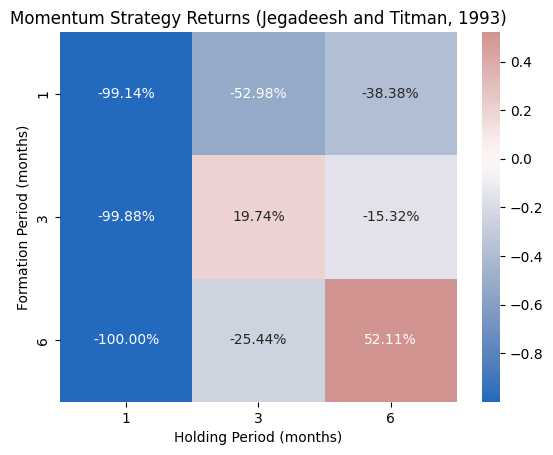

In [4]:
sns.heatmap(result.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
plt.title("Momentum Strategy Returns (Jegadeesh and Titman, 1993)")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")
#plt.savefig("v2-2012.png")  # 将图像保存为heatmap.png
plt.show()